In [1]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.core.mutation import Mutation
from pymoo.core.crossover import Crossover
from pymoo.core.sampling import Sampling
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize

In [2]:
class CustomHybridMutation(Mutation):
    """Custom mutation for permutation (sequence) and integer (machine choices)."""    
    def __init__(self, prob=0.1):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        n_individuals, n_var = X.shape
        # print(f"X shape: {X.shape}")
        # print('X:', X)
        # print('n_individuals:', n_individuals)
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        Y = X.copy()

        for i in range(n_individuals):
            # print('------------------------')
            # Permutation mutation
            if np.random.random() < self.prob:
                # print('before mutation:', Y[i, :seq_length])
                idx1, idx2 = np.random.choice(seq_length, size=2, replace=False)
                Y[i, :seq_length][[idx1, idx2]] = Y[i, :seq_length][[idx2, idx1]]
                # print('after mutation:', Y[i, :seq_length])
            # Machine choice mutation
            machine_choices = Y[i, seq_length:].reshape(seq_length, n_stages)
            # print('before machine mutation: \n', machine_choices)
            for j in range(seq_length):
                for s in range(n_stages):
                    if np.random.random() < self.prob:
                        machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            Y[i, seq_length:] = machine_choices.flatten()
            # print('after machine mutation: \n', Y[i, seq_length:].reshape(seq_length, n_stages))

        return Y.astype(int)

class CustomHybridCrossover(Crossover):
    """Custom crossover for permutation and integer parts."""    
    def __init__(self, prob=0.5):
        super().__init__(2, 2)
        self.prob = prob
        self.order_cx = OrderCrossover()
        self.uniform_cx = UniformCrossover(prob=prob)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape
        # print(f"X shape: {X.shape}")
        # print('X:', X)
        # print('n_matings:', n_matings)
        seq_length = problem.seq_length
        Y = np.zeros_like(X)

        for k in range(n_matings):
            a, b = X[:, k, :]
            # print('------------------------')
            # print(f"Parent A: {a}")
            # print(f"Parent B: {b}")
            perm_a, perm_b = self.order_cx._do(problem, np.array([[a[:seq_length]], [b[:seq_length]]]))[:, 0, :]
            # print(f"Permuted A: {perm_a}")
            # print(f"Permuted B: {perm_b}")
            machine_a, machine_b = self.uniform_cx._do(problem, np.array([[a[seq_length:]], [b[seq_length:]]]))[:, 0, :]
            # print(f"Machine A: {machine_a}")
            # print(f"Machine B: {machine_b}")
            Y[0, k, :seq_length] = perm_a
            Y[1, k, :seq_length] = perm_b
            Y[0, k, seq_length:] = machine_a
            Y[1, k, seq_length:] = machine_b

        return Y.astype(int)

class CustomHybridSampling(Sampling):
    """Custom sampling for permutation and integer parts."""    
    def _do(self, problem, n_samples, **kwargs):
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        X = np.zeros((n_samples, problem.n_var), dtype=int)

        for i in range(n_samples):
            X[i, :seq_length] = np.random.permutation(seq_length)
            machine_choices = np.zeros((seq_length, n_stages), dtype=int)
            for j in range(seq_length):
                for s in range(n_stages):
                    machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            X[i, seq_length:] = machine_choices.flatten()

        return X

In [3]:
class BakeryHybridSchedulingProblem(Problem):
    def __init__(self, user_sequence, recipe_id_to_index, machines_per_stage, processing_times, changeover_times, batch_sizes, tact_times, debug=False):
        self.seq_length = len(user_sequence)
        self.user_sequence = np.array(user_sequence)
        self.recipe_id_to_index = recipe_id_to_index
        self.n_stages = len(machines_per_stage)
        self.machines_per_stage = machines_per_stage
        self.max_makespan = 0
        self.max_machines = max(machines_per_stage)
        self.debug = debug
        n_var = self.seq_length + (self.seq_length * self.n_stages)
        super().__init__(
            n_var=n_var,
            n_obj=1,
            n_constr=0,
            xl=[0] * n_var,
            xu=[self.seq_length - 1] * self.seq_length + [m - 1 for m in machines_per_stage for _ in range(self.seq_length)],
            type_var=int
        )
        self.processing_times = processing_times
        self.changeover_times = changeover_times
        self.batch_sizes = batch_sizes
        self.tact_times = tact_times

    def _evaluate(self, X, out, *args, **kwargs):
        makespans = np.array([self.calculate_makespan(x, store_best=False) for x in X])
        out["F"] = makespans

    def calculate_makespan(self, x, store_best=True):
        perm = x[:self.seq_length]
        machine_choices = x[self.seq_length:].reshape(self.seq_length, self.n_stages)
        seq = self.user_sequence[perm]
        start_times = np.zeros((self.seq_length, self.n_stages))
        end_times = np.zeros((self.seq_length, self.n_stages))
        changeover_times_array = np.zeros((self.seq_length, self.n_stages))
        machine_free_times = np.zeros((self.n_stages, self.max_machines))

        if self.debug and store_best:
            print('recipe_ids:', recipe_ids)
            print(f"Perm: {perm}, Sequence: {[recipe_ids[idx] for idx in seq]}")
            print(f"Machine choices:\n{machine_choices}")

        for i in range(self.seq_length):
            recipe = seq[i]
            prev_recipe = seq[i - 1] if i > 0 else None

            # Compute changeover times
            for s in range(self.n_stages):
                m = machine_choices[i, s]
                if i == 0 or prev_recipe is None:
                    changeover_times_array[i, s] = 0
                else:
                    changeover = self.changeover_times[s, m, prev_recipe, recipe] if prev_recipe != recipe else 0
                    changeover_times_array[i, s] = changeover.item() if isinstance(changeover, np.ndarray) else changeover

            # Compute earliest possible start time for Stage 0
            s = 0
            m = machine_choices[i, s]
            start_times[i, s] = max(0, machine_free_times[s, m])
            if i > 0:
                start_times[i, s] += changeover_times_array[i, s]
            processing_duration = self.processing_times[s, m, recipe]
            batch_delay = (self.batch_sizes[i] - 1) * self.tact_times[recipe]  # Use batch_sizes[i]
            end_times[i, s] = start_times[i, s] + changeover_times_array[i, s] + processing_duration + batch_delay
            machine_free_times[s, m] = end_times[i, s]

            # Compute start and end times for subsequent stages
            for s in range(1, self.n_stages):
                m = machine_choices[i, s]
                prev_stage_end_first = end_times[i, s - 1] - (self.batch_sizes[i] - 1) * self.tact_times[recipe]
                changeover = changeover_times_array[i, s]
                start_times[i, s] = max(prev_stage_end_first + changeover, machine_free_times[s, m])
                if i > 0 and changeover > 0:
                    start_times[i, s] = max(start_times[i, s], machine_free_times[s, m] + changeover)
                processing_duration = self.processing_times[s, m, recipe]
                batch_delay = (self.batch_sizes[i] - 1) * self.tact_times[recipe]
                end_times[i, s] = start_times[i, s] + changeover_times_array[i, s] + processing_duration + batch_delay
                machine_free_times[s, m] = end_times[i, s]

            if self.debug and store_best:
                for s in range(self.n_stages):
                    m = machine_choices[i, s]
                    print(f"Recipe {i} (ID {recipe_ids[recipe]}): Stage {s}, Machine {m}: "
                          f"Start = {start_times[i, s]}, Changeover = {changeover_times_array[i, s]}, "
                          f"Processing = {self.processing_times[s, m, recipe]}, Batch Delay = {batch_delay}, "
                          f"End = {end_times[i, s]}, Machine free at = {machine_free_times[s, m]}")

        makespan = np.max(end_times)
    
        # Penalize the number of unique machines used
        unique_machines_used = 0
        for s in range(self.n_stages):
            unique_machines_used += len(np.unique(machine_choices[:, s]))
        # You can adjust the penalty weight (e.g., 10.0)
        penalty_weight = 5.0
        penalty = penalty_weight * unique_machines_used

        penalized_makespan = makespan + penalty

        if self.debug and store_best:
            print(f"Unique machines used: {unique_machines_used}, Penalty: {penalty}, Penalized makespan: {penalized_makespan}")

        if store_best:
            self.best_start_times = start_times
            self.best_end_times = end_times
            self.best_machine_choices = machine_choices
            self.best_sequence_ids = [recipe_ids[idx] for idx in seq]
            self.best_changeover_times = changeover_times_array
            self.max_makespan = makespan

        return penalized_makespan
    
    
    def get_best_solution(self):
        return {
            "start_times": self.best_start_times,
            "end_times": self.best_end_times,
            "machine_choices": self.best_machine_choices,
            "sequence_ids": self.best_sequence_ids,
            "changeover_times": self.best_changeover_times,
            "makespan": self.max_makespan
        }


    def plot_gantt_chart(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        stage_labels = [f"Stage {s} (Machine {m})" for s in range(self.n_stages) for m in range(self.machines_per_stage[s])]
        y_positions = np.arange(len(stage_labels))
        colors = {recipe_id: plt.cm.Set3(i) for i, recipe_id in enumerate(np.unique(self.best_sequence_ids))}

        # Build job labels with occurrence numbers
        recipe_counts = defaultdict(int)
        recipe_total_counts = Counter(self.best_sequence_ids)
        job_labels = []
        for rid in self.best_sequence_ids:
            recipe_counts[rid] += 1
            if recipe_total_counts[rid] > 1:
                job_labels.append(f"{rid} ({recipe_counts[rid]})")
            else:
                job_labels.append(f"{rid}")

        # Add striped background for each stage
        stage_start_idx = 0
        for s in range(self.n_stages):
            n_machines = self.machines_per_stage[s]
            stage_end_idx = stage_start_idx + n_machines
            if s % 2 == 0:
                ax.axhspan(stage_start_idx - 0.5, stage_end_idx - 0.5, facecolor="#ffffff", alpha=0.5, zorder=0)
            else:
                ax.axhspan(stage_start_idx - 0.5, stage_end_idx - 0.5, facecolor='#f5f5dc', alpha=0.5, zorder=0)
            stage_start_idx = stage_end_idx

        for i in range(self.seq_length):
            recipe_id = self.best_sequence_ids[i]
            label = job_labels[i]
            for s in range(self.n_stages):
                m = self.best_machine_choices[i, s]
                stage_idx = sum(self.machines_per_stage[:s]) + m
                if self.best_start_times[i, s] < self.best_end_times[i, s]:
                    if self.best_changeover_times[i, s] > 0:
                        ax.barh(y_positions[stage_idx], self.best_changeover_times[i, s],
                                left=self.best_start_times[i, s], height=0.5, color='red', edgecolor='black', alpha=0.7,
                                label='Changeover' if i == 0 and s == 0 else "")
                        process_start = self.best_start_times[i, s] + self.best_changeover_times[i, s]
                    else:
                        process_start = self.best_start_times[i, s]
                    process_duration = ((self.best_end_times[i, s] - self.best_start_times[i, s]) -
                                        self.best_changeover_times[i, s])

                    ax.barh(y_positions[stage_idx], process_duration,
                            left=process_start, height=0.5, color=colors[recipe_id], edgecolor='black')
                    # Use job label instead of just recipe_id
                    ax.text(process_start + process_duration / 2, y_positions[stage_idx], label,
                            ha='center', va='center', color='white', fontweight='bold')

        ax.set_yticks(y_positions)
        ax.set_yticklabels(stage_labels)
        ax.set_xlabel("Time")
        ax.set_title("Batch Production Scheduling - Multi-stage Flowshop Optimization")
        ax.set_xlim(0, self.max_makespan + 10)
        ax.set_ylim(-0.5, len(stage_labels) - 0.5)
        handles = [plt.Rectangle((0,0),1,1, color=colors[rid], label=str(rid)) for rid in colors.keys()]
        handles.append(plt.Rectangle((0,0),1,1, color='red', alpha=0.7, label='Changeover'))
        ax.legend(handles=handles, loc='best', title="Recipe IDs")
        plt.tight_layout()
        plt.show()



In [4]:
# Example setup
recipe_ids = [1, 3, 4, 5, 8, 14]
recipe_id_to_index = {rid: idx for idx, rid in enumerate(recipe_ids)}

# User's sequence (8 positions)
user_sequence_ids = [3, 1, 5, 8, 14, 3, 5, 5]
user_sequence_idx = [recipe_id_to_index[rid] for rid in user_sequence_ids]

# Problem parameters
n_stages = 5
n_recipes = len(recipe_ids)
machines_per_stage = [1, 2, 1, 2, 3]
max_machines = max(machines_per_stage)

# Sample data
np.random.seed(42)
processing_times = np.random.randint(5, 20, size=(n_stages, max_machines, n_recipes))
changeover_times = np.random.randint(1, 5, size=(n_stages, max_machines, n_recipes, n_recipes))
for s in range(n_stages):
    for m in range(machines_per_stage[s]):
        for i in range(n_recipes):
            changeover_times[s, m, i, i] = 0  # No changeover for same recipe
# Define batch_sizes to match the sequence length
batch_sizes = [10, 20, 15, 5, 30, 15, 25, 25]  # Example quantities for each position in the sequence
tact_times = np.random.uniform(0.5, 2.0, size=n_recipes)

# Debug print input data
print("recipe_ids:", recipe_ids)
print("recipe_id_to_index:", recipe_id_to_index)
print("User sequence IDs:", user_sequence_ids)
print("User sequence indices:", user_sequence_idx)
print("\n")
print("Batch sizes:", batch_sizes)
print("Tact times:", tact_times)
print("\n")
print("Processing times:\n", processing_times)
print("Changeover times:\n", changeover_times)

recipe_ids: [1, 3, 4, 5, 8, 14]
recipe_id_to_index: {1: 0, 3: 1, 4: 2, 5: 3, 8: 4, 14: 5}
User sequence IDs: [3, 1, 5, 8, 14, 3, 5, 5]
User sequence indices: [1, 0, 3, 4, 5, 1, 3, 3]


Batch sizes: [10, 20, 15, 5, 30, 15, 25, 25]
Tact times: [0.75994148 0.73465556 0.87536435 1.32384    1.57189388 1.49029607]


Processing times:
 [[[11  8 17 19 15 12]
  [17  9 11 14  7 11]
  [15 15 12  9  8 12]]

 [[12  7 10  9  6 12]
  [16 18 10  6 16  9]
  [ 5 16 14 10 17 16]]

 [[13  5 15 15 19 14]
  [16 16 19 18 18 19]
  [18  7 16 11  8 13]]

 [[ 7  9  7 11  9 13]
  [11  6  8 13 16 18]
  [ 6 14 13 14  9  6]]

 [[ 8 16 19 16 11 16]
  [17 12 19  7 18  5]
  [ 8  6 12  8  6 18]]]
Changeover times:
 [[[[0 2 2 4 2 1]
   [3 0 2 4 2 2]
   [2 4 0 3 4 3]
   [4 2 3 0 1 2]
   [4 1 4 1 0 3]
   [1 4 2 1 4 0]]

  [[4 1 1 1 3 1]
   [1 1 3 1 4 1]
   [4 4 4 3 3 3]
   [1 4 3 3 1 3]
   [1 2 3 2 1 4]
   [3 1 4 4 2 1]]

  [[4 3 3 2 4 1]
   [3 4 4 2 3 3]
   [1 3 1 3 2 3]
   [1 1 2 3 3 2]
   [3 3 1 3 3 2]
   [2 4 1 3 3 4]]

In [5]:
# Create the problem instance
problem = BakeryHybridSchedulingProblem(
    user_sequence=user_sequence_idx,
    recipe_id_to_index=recipe_id_to_index,
    machines_per_stage=machines_per_stage,
    processing_times=processing_times,
    changeover_times=changeover_times,
    batch_sizes=batch_sizes,
    tact_times=tact_times,
    debug=True
)

# Define the genetic algorithm
algorithm = GA(
    pop_size=150,
    sampling=CustomHybridSampling(),
    crossover=CustomHybridCrossover(prob=0.5),
    mutation=CustomHybridMutation(prob=0.15),
    eliminate_duplicates=True
)

# Define termination criteria
termination = DefaultSingleObjectiveTermination(
    xtol=1e-6,
    cvtol=1e-6,
    ftol=1e-6,
    period=50,
    n_max_gen=200
)

# Run the optimization
res = minimize(
    problem,
    algorithm,
    termination,
    seed=42,
    verbose=True
)

c:\Users\NHPHUC\Desktop\schantt-model\.venv\lib\site-packages\pymoo\util\normalization.py:86: RuntimeWarning: invalid value encountered in cast
  N[..., neither_nan] = (X[..., neither_nan] - xl[neither_nan]) / (xu[neither_nan] - xl[neither_nan])


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      150 |  4.206469E+02 |  3.837535E+02
     2 |      300 |  4.080710E+02 |  3.752504E+02
     3 |      450 |  3.995388E+02 |  3.715766E+02
     4 |      600 |  3.946494E+02 |  3.715766E+02
     5 |      750 |  3.893536E+02 |  3.715766E+02
     6 |      900 |  3.845318E+02 |  3.676305E+02
     7 |     1050 |  3.805970E+02 |  3.676305E+02
     8 |     1200 |  3.777904E+02 |  3.654682E+02
     9 |     1350 |  3.757360E+02 |  3.654682E+02
    10 |     1500 |  3.734474E+02 |  3.584682E+02
    11 |     1650 |  3.710712E+02 |  3.584682E+02
    12 |     1800 |  3.680832E+02 |  3.584682E+02
    13 |     1950 |  3.658231E+02 |  3.584682E+02
    14 |     2100 |  3.643470E+02 |  3.584682E+02
    15 |     2250 |  3.632691E+02 |  3.584682E+02
    16 |     2400 |  3.619960E+02 |  3.584682E+02
    17 |     2550 |  3.609293E+02 |  3.584682E+02
    18 |     2700 |  3.597227E+02 |  3.584682E+02
    19 |     2850 |  3.586360E+02 |  3.584682E+02


recipe_ids: [1, 3, 4, 5, 8, 14]
Perm: [3 5 0 4 1 2 6 7], Sequence: [8, 3, 3, 14, 1, 5, 5, 5]
Machine choices:
[[0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 1 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 1 0 0 1]]
Recipe 0 (ID 8): Stage 0, Machine 0: Start = 0.0, Changeover = 0.0, Processing = 15, Batch Delay = 14.147044956450841, End = 29.14704495645084, Machine free at = 29.14704495645084
Recipe 0 (ID 8): Stage 1, Machine 0: Start = 15.0, Changeover = 0.0, Processing = 6, Batch Delay = 14.147044956450841, End = 35.14704495645084, Machine free at = 35.14704495645084
Recipe 0 (ID 8): Stage 2, Machine 0: Start = 21.0, Changeover = 0.0, Processing = 19, Batch Delay = 14.147044956450841, End = 54.14704495645084, Machine free at = 54.14704495645084
Recipe 0 (ID 8): Stage 3, Machine 0: Start = 40.0, Changeover = 0.0, Processing = 9, Batch Delay = 14.147044956450841, End = 63.14704495645084, Machine free at = 63.14704495645084
Recipe 0 (ID 8): Stage 4, Machine 1: Start = 49.0, Changeover = 

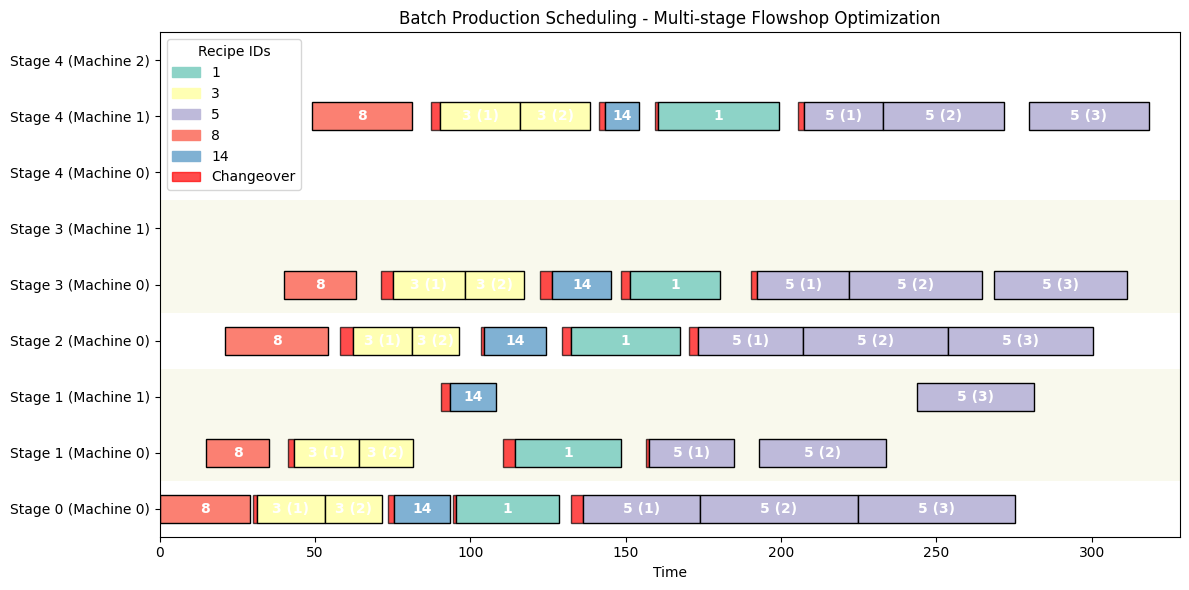

In [6]:
# Extract and display results
best_x = res.X
best_perm = best_x[:problem.seq_length]
best_machine_choices = best_x[problem.seq_length:].reshape(problem.seq_length, problem.n_stages)
best_sequence_idx = [user_sequence_idx[i] for i in best_perm]
best_sequence_ids = [recipe_ids[idx] for idx in best_sequence_idx]

# Recompute the makespan for the best solution
penalized_makespan = problem.calculate_makespan(best_x, store_best=True)
problem.best_perm = best_perm
problem.best_machine_choices = best_machine_choices
problem.best_sequence_ids = best_sequence_ids


print("Original sequence of recipe IDs:", user_sequence_ids)
print("Best permutation of indices:", best_perm)
print("Best sequence of recipe IDs:", best_sequence_ids)
print("Best machine choices per recipe and stage:\n", best_machine_choices)
print("Penalized makespan:", penalized_makespan)
print('Best makespan:', problem.max_makespan)

# Generate and display the Gantt chart
problem.plot_gantt_chart()